<a href="https://colab.research.google.com/github/gonzalootero55/data-portfolio/blob/main/credit_risk_analysis_lending_club.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objetivo del proyecto

Este proyecto analiza el riesgo crediticio utilizando un dataset público de Lending Club, una empresa prestamista de Estados Unidos.

El dataset contiene información histórica de préstamos otorgados entre los años 2007 y 2015, y se utiliza con fines demostrativos para el análisis del comportamiento de incumplimiento crediticio.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

path = "/content/drive/MyDrive/loan.csv"
df = pd.read_csv(path)

/tmp/ipython-input-1012606944.py:4: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


## Fuente de datos

El análisis se realiza sobre datos históricos de préstamos otorgados entre 2007 y 2015. Los resultados deben interpretarse como un análisis histórico del riesgo crediticio durante un período amplio.

## Carga y revisión inicial

Se cargó el dataset y se realizó una revisión inicial de sus dimensiones y variables disponibles para comprender su estructura general.

In [ ]:
df.head()
df.shape
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=145)

## Selección de variables relevantes

El dataset original contiene una gran cantidad de variables. Para este análisis se seleccionaron únicamente aquellas relevantes para evaluar el riesgo crediticio en la etapa de originación del préstamo, con el objetivo de reducir ruido y enfocar el análisis.

## Variables utilizadas:

loan_amnt: monto del préstamo

term: plazo del préstamo (36 o 60 meses)

int_rate: tasa de interés

grade / sub_grade: calificación de riesgo del cliente

emp_length: antigüedad laboral

annual_inc: ingreso anual

loan_status: estado del préstamo

issue_d: fecha de otorgamiento

In [ ]:
cols = [
    "loan_amnt",
    "term",
    "int_rate",
    "grade",
    "sub_grade",
    "emp_length",
    "annual_inc",
    "loan_status",
    "issue_d"
]

df = df[cols]

## Definición de default

Se definió una variable binaria de default a partir del estado del préstamo (loan_status).

Se consideró como default a aquellos préstamos en estados de mora relevantes, como préstamos cargados como incobrables, en default o con atrasos prolongados.

Esta transformación permite analizar el riesgo crediticio de forma cuantitativa.

### Interpretación

1 = préstamo en default

0 = préstamo sin incumplimiento

In [ ]:
df["default"] = df["loan_status"].isin(
    ["Charged Off", "Default", "Late (31-120 days)"]
).astype(int)

## Riesgo general de la cartera

Como primer paso, se calculó la tasa de default total de la cartera para tener una referencia general del nivel de riesgo.

### Resultado

La tasa de default de la cartera es aproximadamente del 12–13%, lo que indica un nivel de riesgo moderado.

In [ ]:
df["default"].value_counts(normalize=True)

,proportion
default,
0,0.874558
1,0.125442


0 → 0.874558 → 87,45% NO default

1 → 0.125442 → 12,54% default

In [ ]:
df = df.dropna(subset=["annual_inc", "emp_length"])


Eliminé filas donde falte información clave del cliente.

## Uso de SQL en el análisis

Si bien la tasa de default puede calcularse directamente utilizando herramientas de análisis en Python, se replica el cálculo mediante SQL con el objetivo de simular un entorno de trabajo real en banca, donde los datos suelen residir en bases de datos relacionales.

In [ ]:
import sqlite3

conn = sqlite3.connect(":memory:")
df.to_sql("prestamos", conn, index=False, if_exists="replace")

2113757

In [ ]:
query = """
SELECT COUNT(*) AS total_prestamos
FROM prestamos;
"""

pd.read_sql(query, conn)


,total_prestamos
0,2113757


## Validación de resultados

Se recalcula la tasa de default utilizando SQL para validar la consistencia de los resultados obtenidos previamente y asegurar que las métricas clave se mantengan estables independientemente de la herramienta utilizada.

In [ ]:
query = """
SELECT
  AVG("default") AS tasa_default
FROM prestamos;
"""

pd.read_sql(query, conn)


,tasa_default
0,0.123596


## Default por grade

Análisis por calificación de riesgo

Se segmentó la cartera por grade y se calculó la tasa de default en cada grupo.

Los resultados muestran que a medida que empeora la calificación, aumenta de forma consistente la tasa de incumplimiento, lo que valida la lógica del sistema de calificación de riesgo.

In [ ]:
query = """
SELECT
  grade,
  COUNT(*) AS total_prestamos,
  AVG("default") AS tasa_default
FROM prestamos
GROUP BY grade
ORDER BY tasa_default DESC;
"""
pd.read_sql(query, conn)


,grade,total_prestamos,tasa_default
0,G,11511,0.388672
1,F,39438,0.357118
2,E,127087,0.276393
3,D,301786,0.196576
4,C,607585,0.137726
5,B,620424,0.082121
6,A,405926,0.033538


## Default por plazo (term)

Análisis por plazo del préstamo

Se analizó la tasa de default según el plazo del préstamo.

Los créditos a 60 meses presentan mayores tasas de incumplimiento que los de 36 meses, lo cual es consistente con una mayor exposición al riesgo en el tiempo.

In [ ]:
query = """
SELECT
  term,
  COUNT(*) AS total_prestamos,
  AVG("default") AS tasa_default
FROM prestamos
GROUP BY term
ORDER BY tasa_default DESC;
"""
pd.read_sql(query, conn)


,term,total_prestamos,tasa_default
0,60 months,620367,0.170878
1,36 months,1493390,0.103955


Agrupa los préstamos por plazo (36 vs 60 meses)

Cuenta cuántos préstamos hay en cada plazo

Calcula la tasa de default en cada grupo

“Analicé la tasa de default según el plazo del préstamo y observé que los créditos a mayor plazo presentan mayor incumplimiento, lo cual es consistente con una mayor exposición al riesgo en el tiempo.”

## Default por nivel de ingresos

Análisis por nivel de ingresos

Se segmentó la cartera en grupos de ingresos bajos, medios y altos utilizando SQL.

Se observa que los clientes con menores ingresos presentan mayores niveles de default, reflejando una menor capacidad de pago.

### Observación adicional

Si bien el segmento de ingresos bajos tiene mayor tasa de default, el mayor volumen de préstamos se concentra en ingresos medios.

In [ ]:
query = """
SELECT
  CASE
    WHEN annual_inc < 40000 THEN 'Ingreso bajo'
    WHEN annual_inc BETWEEN 40000 AND 80000 THEN 'Ingreso medio'
    ELSE 'Ingreso alto'
  END AS segmento_ingreso,
  COUNT(*) AS total_prestamos,
  AVG("default") AS tasa_default
FROM prestamos
GROUP BY segmento_ingreso
ORDER BY tasa_default DESC;
"""
pd.read_sql(query, conn)


,segmento_ingreso,total_prestamos,tasa_default
0,Ingreso bajo,287221,0.145822
1,Ingreso medio,1083872,0.132510
2,Ingreso alto,742664,0.101991


## Análisis combinado de riesgo

Se realizó un análisis conjunto entre la calificación de riesgo y el plazo del préstamo.

Los resultados muestran que, incluso dentro del mismo grade, los préstamos a mayor plazo presentan mayores tasas de default, evidenciando que el plazo incrementa el riesgo crediticio.

In [ ]:
query = """
SELECT
  grade,
  term,
  COUNT(*) AS total_prestamos,
  AVG("default") AS tasa_default
FROM prestamos
GROUP BY grade, term
ORDER BY grade, term;
"""
pd.read_sql(query, conn)


,grade,term,total_prestamos,tasa_default
0,A,36 months,383125,0.033785
1,A,60 months,22801,0.029385
2,B,36 months,497824,0.084532
3,B,60 months,122600,0.072333
4,C,36 months,387946,0.139122
5,C,60 months,219639,0.135258
6,D,36 months,168722,0.190206
7,D,60 months,133064,0.204653
8,E,36 months,46041,0.238765
9,E,60 months,81046,0.297769


## Conclusiones

- La cartera presenta una tasa de default moderada, cercana al 12–13%.

- El grade discrimina correctamente el riesgo crediticio.

- El plazo del préstamo es un factor relevante que incrementa el riesgo.

- Los clientes con menores ingresos presentan mayores niveles de incumplimiento.

- El riesgo crediticio surge de la combinación de múltiples factores y no de una sola variable.

## Nota final

Este proyecto tiene un enfoque demostrativo y busca mostrar el uso de análisis de datos y SQL para comprender el comportamiento del riesgo crediticio en una cartera real.

In [ ]:
query = """
SELECT
  grade,
  AVG("default") AS tasa_default
FROM prestamos
GROUP BY grade
ORDER BY grade;
"""
df_grade = pd.read_sql(query, conn)
df_grade


,grade,tasa_default
0,A,0.033538
1,B,0.082121
2,C,0.137726
3,D,0.196576
4,E,0.276393
5,F,0.357118
6,G,0.388672


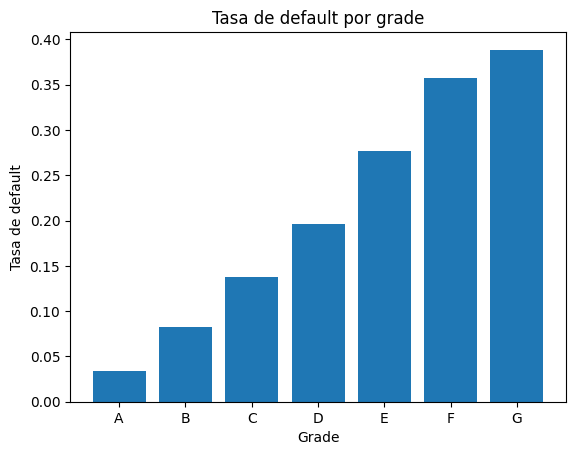

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(df_grade["grade"], df_grade["tasa_default"])
plt.xlabel("Grade")
plt.ylabel("Tasa de default")
plt.title("Tasa de default por grade")
plt.show()


“Este gráfico muestra que a medida que empeora el grade, aumenta la tasa de incumplimiento, validando la lógica del sistema de riesgo.”

In [ ]:
query = """
SELECT
  term,
  AVG("default") AS tasa_default
FROM prestamos
GROUP BY term;
"""
df_term = pd.read_sql(query, conn)
df_term


,term,tasa_default
0,36 months,0.103955
1,60 months,0.170878


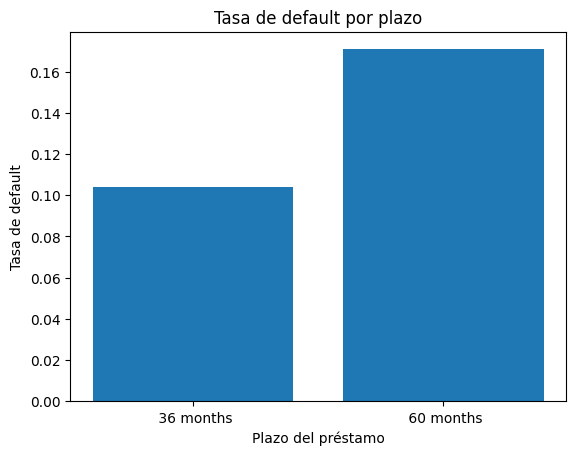

In [ ]:
plt.figure()
plt.bar(df_term["term"], df_term["tasa_default"])
plt.xlabel("Plazo del préstamo")
plt.ylabel("Tasa de default")
plt.title("Tasa de default por plazo")
plt.show()


“Los préstamos a mayor plazo presentan mayor tasa de incumplimiento debido a la mayor exposición al riesgo en el tiempo.”

In [ ]:
query = """
SELECT
  grade,
  term,
  AVG("default") AS tasa_default
FROM prestamos
GROUP BY grade, term
ORDER BY grade, term;
"""
df_grade_term = pd.read_sql(query, conn)
df_grade_term


,grade,term,tasa_default
0,A,36 months,0.033785
1,A,60 months,0.029385
2,B,36 months,0.084532
3,B,60 months,0.072333
4,C,36 months,0.139122
5,C,60 months,0.135258
6,D,36 months,0.190206
7,D,60 months,0.204653
8,E,36 months,0.238765
9,E,60 months,0.297769


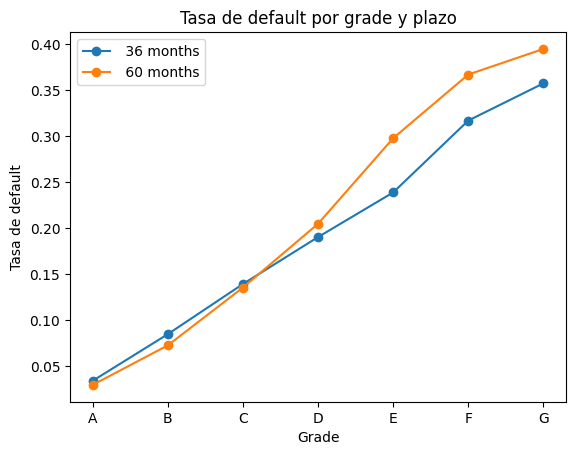

In [ ]:
grades = df_grade_term["grade"].unique()
terms = df_grade_term["term"].unique()

for term in terms:
    subset = df_grade_term[df_grade_term["term"] == term]
    plt.plot(subset["grade"], subset["tasa_default"], marker='o', label=term)

plt.xlabel("Grade")
plt.ylabel("Tasa de default")
plt.title("Tasa de default por grade y plazo")
plt.legend()
plt.show()


“Incluso dentro del mismo grade, los préstamos a mayor plazo presentan mayores tasas de default, lo que muestra que el plazo agrega riesgo adicional.”

In [ ]:
df.to_csv("prestamos_riesgo.csv", index=False)


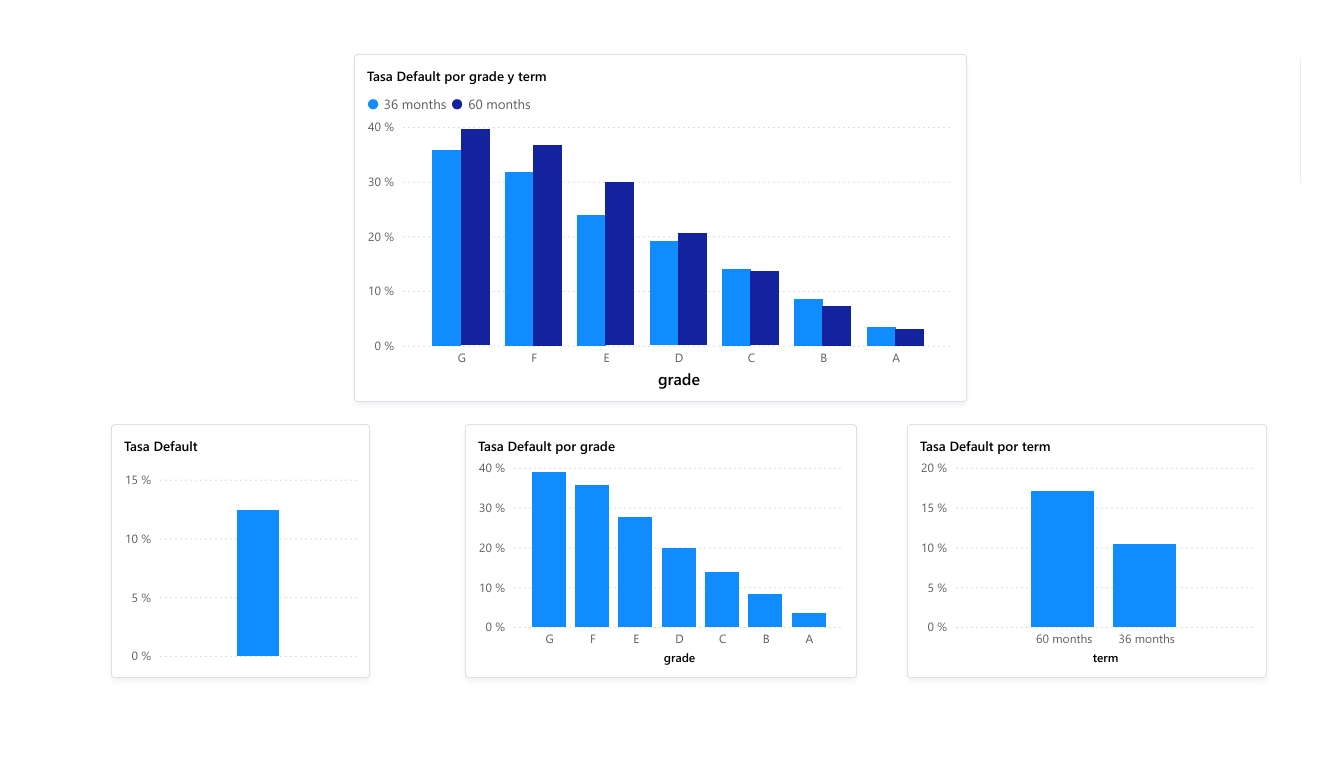